# Next

- Tentar fine-tune a MobileNet
- Debugar os conjuntos de dados
- Quais ele falha (camera, angulo, genero, etc)

In [9]:
from keras.applications.mobilenet import MobileNet, preprocess_input


image_shape = (224, 224, 3)
nb_classes = 12
nb_frames = 12

features_extractor = MobileNet(include_top=False, input_shape=image_shape)

In [18]:
from keras.layers import Input, Conv3D, Dense, Flatten, concatenate
from keras.layers.wrappers import TimeDistributed
from keras.models import Model


def get_model(extractor, nb_classes=12, nb_frames=8, image_shape=(128, 128, 3)):
    video_input = Input(shape=(nb_frames, *image_shape), dtype='float32', name='input')
        
    # extrator de features espaciais
    td_extractor = TimeDistributed(
            extractor, 
            input_shape=(nb_frames, *image_shape), 
            name='f_extractor'
    )(video_input)
    
    # bloco_1
    block_1 = Conv3D(32, (3, 2, 2), activation='elu')(td_extractor)
    block_1 = Conv3D(64, (4, 3, 3), activation='elu')(block_1)
    block_1 = Conv3D(128, (4, 3, 3), activation='elu')(block_1)
    block_1 = Conv3D(256, (4, 2, 2), activation='elu')(block_1)

    # bloco_2
    block_2 = Conv3D(32, (3, 2, 2), activation='elu')(td_extractor)
    block_2 = Conv3D(64, (4, 3, 3), activation='elu')(block_2)
    block_2 = Conv3D(128, (4, 3, 3), activation='elu')(block_2)
    block_2 = Conv3D(256, (4, 2, 2), activation='elu')(block_2)
    
    # bloco_3
    block_3 = Conv3D(32, (3, 2, 2), activation='elu')(td_extractor)
    block_3 = Conv3D(64, (4, 3, 3), activation='elu')(block_3)
    block_3 = Conv3D(128, (4, 3, 3), activation='elu')(block_3)
    block_3 = Conv3D(256, (4, 2, 2), activation='elu')(block_3)
    
    
    # merge
    features = concatenate([
            Flatten()(block_1), 
            Flatten()(block_2),
            Flatten()(block_3)
    ])
    
    # classifier
    classfier = Dense(256, activation='elu')(features)
    classfier = Dense(256, activation='elu')(classfier)
    classfier = Dense(nb_classes, activation='softmax')(classfier)
    
    return Model(inputs=[video_input], outputs=[classfier])


model = get_model(
        features_extractor, 
        nb_classes=nb_classes, 
        nb_frames=nb_frames, 
        image_shape=image_shape)

# congela as layers do extractor
for layer in model.layers[1].layer.layers[:]:
    layer.trainable = False
    
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 12, 224, 224, 0                                            
__________________________________________________________________________________________________
f_extractor (TimeDistributed)   (None, 12, 7, 7, 102 3228864     input[0][0]                      
__________________________________________________________________________________________________
conv3d_134 (Conv3D)             (None, 10, 6, 6, 32) 393248      f_extractor[0][0]                
__________________________________________________________________________________________________
conv3d_138 (Conv3D)             (None, 10, 6, 6, 32) 393248      f_extractor[0][0]                
__________________________________________________________________________________________________
conv3d_142

In [ ]:
from keras.models import Sequential
from keras.layers import Activation, BatchNormalization, Conv3D, Dense, Dropout, Flatten
from keras.layers.wrappers import TimeDistributed


def get_model(extractor, nb_classes=12, nb_frames=8, image_shape=(128, 128, 3), summary=False):
    model = Sequential()
    
    # spatial feature extractor
    model.add(TimeDistributed(extractor, input_shape=(nb_frames, *image_shape)))
        
    # temporal feature extractor
    model.add(Conv3D(32, (3, 2, 2)))
    model.add(Activation('elu'))      
    
    model.add(Conv3D(64, (3, 2, 2)))
    model.add(Activation('elu'))
    
    model.add(Conv3D(128, (3, 2, 2)))
    model.add(Activation('elu'))      
    
    model.add(Conv3D(256, (3, 2, 2)))
    model.add(Activation('elu'))    
    
    # classifier  
    model.add(Flatten())

    model.add(Dense(256))
    model.add(Activation('elu'))
    
    model.add(Dense(256))
    model.add(Activation('elu'))
    
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    
    for layer in model.layers[0].layer.layers[:]:
        layer.trainable = False    
    
    if summary:
        print(model.summary())
        
    return model


model = get_model(
        features_extractor, 
        nb_classes=nb_classes, 
        nb_frames=nb_frames, 
        image_shape=image_shape, 
        summary=True)

In [19]:
from keras.optimizers import SGD


model.compile(loss='categorical_crossentropy', 
              optimizer=SGD(lr=0.0005),
              metrics=['acc'])

In [20]:
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.preprocessing.image import (
    flip_axis, transform_matrix_offset_center, apply_transform
)


# assume que as imagens sempre serao `last_channel`
    
def rotation_matrix(X, rg):
    theta = np.deg2rad(np.random.uniform(-rg, rg))
    return np.array([[np.cos(theta), -np.sin(theta), 0],
                     [np.sin(theta), np.cos(theta), 0],
                     [0, 0, 1]])

def shift_matrix(X, wrg, hrg, row_axis=1, col_axis=2):
    dx = np.random.uniform(-hrg, hrg)
    dy = np.random.uniform(-wrg, wrg)
    h, w = X[0].shape[row_axis], X[0].shape[col_axis]
    tx = dx * h
    ty = dy * w
    return np.array([[1, 0, tx],
                     [0, 1, ty],
                     [0, 0, 1]])

def shear_matrix(X, intensity):
    shear = np.deg2rad(np.random.uniform(-intensity, intensity))
    return np.array([[1, -np.sin(shear), 0],
                     [0, np.cos(shear), 0],
                     [0, 0, 1]])

def zoom_matrix(X, zoom_range):
    zx, zy = np.random.uniform(zoom_range[0], zoom_range[1], 2)  
    return np.array([[zx, 0, 0],
                     [0, zy, 0],
                     [0, 0, 1]])

def random_seq_transform(X, rtrg=0, wrg=0, hrg=0, shrg=0, zrg=0, row_axis=1, col_axis=2, channel_axis=2,
                    fill_mode='nearest', cval=0.):
    transform_matrix = None
    
    if rtrg != 0:
        transform_matrix = rotation_matrix(X, rtrg)
    if wrg != 0 or hrg != 0:
        shift = shift_matrix(X, wrg, hrg, row_axis=row_axis, col_axis=col_axis)
        transform_matrix = shift if transform_matrix is None else np.dot(transform_matrix, shift)
    if shrg != 0:
        shear = shear_matrix(X, shrg)
        transform_matrix = shear if transform_matrix is None else np.dot(transform_matrix, shear)
    if zrg != 0:
        zoom = zoom_matrix(X, zrg)
        transform_matrix = zoom if transform_matrix is None else np.dot(transform_matrix, zoom)
    
    if not transform_matrix is None:
        h, w = X[0].shape[row_axis], X[0].shape[col_axis]
        transform_matrix = transform_matrix_offset_center(transform_matrix, h, w)        
        
        Xr = []
        
        for x in X:
            Xr.append(apply_transform(x, transform_matrix, channel_axis, fill_mode, cval))
        
        return np.array(Xr)
    else:
        return X

def flip(img):
    """reflete a imagem em relacao ao eixo y."""
    return flip_axis(img, axis=1)

def interval_mapping(image, from_min, from_max, to_min, to_max):
    from_range = from_max - from_min
    to_range = to_max - to_min
    scaled = np.array((image - from_min) / float(from_range), dtype=float)
    return to_min + (scaled * to_range)

def read_video(video_path, size=(128, 128, 3), gray_scale=False):
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    frames = []
    
    while ret:
        if gray_scale:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        if frame.shape != size:
            frame = cv2.resize(frame, (size[1], size[0]))
        frames.append(frame)
        ret, frame = cap.read()
    
    return frames

In [26]:
import os
import threading
from functools import reduce


def preprocess(video_path, 
               nb_frames=12, 
               size=(128, 128, 3), 
               start_offset_rg=5, 
               rtrg=12.5, 
               wrg=0.10, 
               hrg=0.05, 
               shrg=10, 
               zrg=0.12,
               toflip=False,
               data_augmentation=True):
    video = []
    
    if toflip and random.randint(0, 1) == 0:
        toflip = False
        
    for frame in read_video(video_path, size=size):
        frame = preprocess_input(frame.astype(np.float64))
        if toflip:
            flip(frame)
        video.append(frame)

    middle = len(video)//2
    start = middle - nb_frames
    end = middle + nb_frames
    video = [frame for frame in video[start:end:2]]
    
    while len(video) < nb_frames:
        video.append(np.zeros(size))
    
    if data_augmentation:
        return random_seq_transform(np.array(video[:nb_frames]), 
                                    rtrg,
                                    wrg, 
                                    hrg,
                                    shrg,
                                    (1.0-zrg, 1.0+zrg))
    else:
        return np.array(video[:nb_frames], dtype=np.float32)
    
def generator(features, labels, batch_size, nb_frames=12, size=(128, 128, 3), data_augmentation=True):
    batch_features = np.zeros((batch_size, nb_frames, *size))
    batch_labels = np.zeros((batch_size, len(labels)))
    
    random.shuffle(features)
    lock = threading.Lock()
    index = 0
    
    # not thread-safe
    def pick(features):
        nonlocal index
        with lock:
            if index == len(features):
                random.shuffle(features)
                index = 0
            feature = features[index]
            index += 1
        return feature

    while True:
        for i in range(batch_size):
            feature, label = pick(features)
            batch_labels[i] = labels[label]
            batch_features[i] = preprocess(
                    feature, 
                    nb_frames=nb_frames, 
                    size=size, 
                    data_augmentation=data_augmentation,
                    toflip=True)
        yield batch_features, batch_labels

def load(dataset_path, _class):
    videos_path = []

    for root, subdir, filesname in os.walk(dataset_path):
        for filename in filesname:
            if '.mp4' in filename:
                videos_path.append(os.path.join(root, filename))

    features = []
    labels = to_categorical(range(len(_class)))

    for i, c in enumerate(_class):
        for path in videos_path:
            if c + '/' in path:
                features.append((path, i))
    
    return features, labels


dataset_path = 'dataset/training'
validation_path = 'dataset/validation'
batch_size = 1
_class = ['avisar', 'avisar-me',
          'sentimento', 'agosto',
          'quente', 'rápido',
          'pessoa', 'esquecer',
          'entender', 'entender-não',
          'branco', 'educado']


features, labels = load(dataset_path, _class)
vfeatures, vlabels = load(validation_path, _class)

gen = generator(features, labels, batch_size, nb_frames=nb_frames, size=image_shape)
vgen = generator(vfeatures, vlabels, batch_size, nb_frames=nb_frames, size=image_shape, data_augmentation=False)

In [24]:
%%time
# debugar se esta gerando corretamenta as imagens
batch, label = next(gen)

CPU times: user 396 ms, sys: 44.9 ms, total: 440 ms
Wall time: 320 ms


(1, 12, 224, 224, 3) (1, 12)


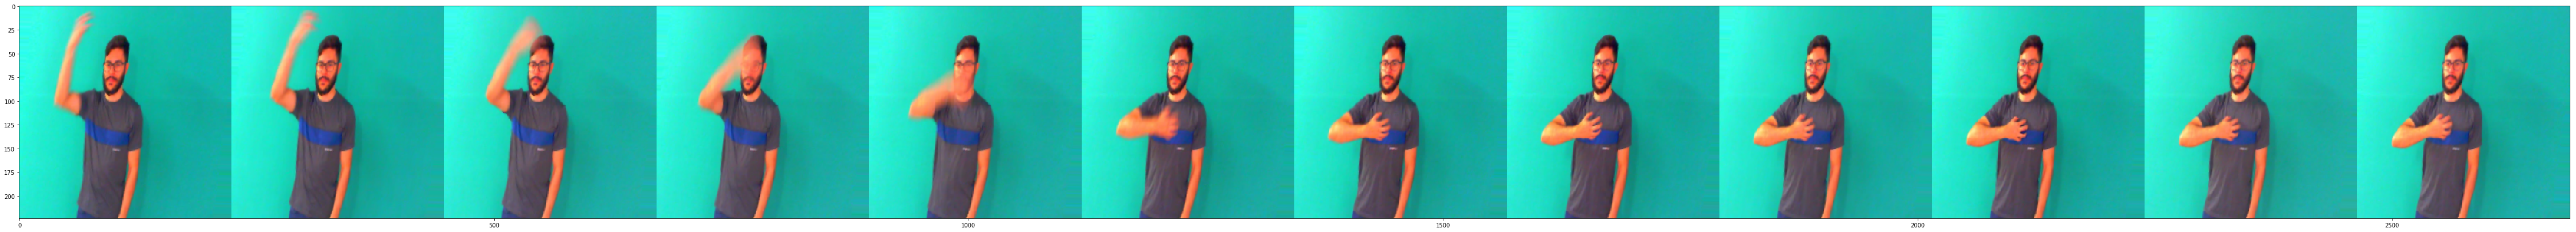

CPU times: user 2.22 s, sys: 288 ms, total: 2.51 s
Wall time: 2.16 s


In [25]:
%%time
print(batch.shape, label.shape)

img = np.concatenate([interval_mapping(img, np.min(img), np.max(img), 0, 255).astype(np.uint8)
                for img in batch[0]], axis=1)

plt.figure(figsize=(80,40))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [27]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint


def schedule(epoch, lr):
    if epoch == 0:
        return lr
    elif epoch % 2 == 0:
        return lr / 5
    else:
        return lr / 2

checkpointer = ModelCheckpoint(filepath='/tmp/weights.hdf5', verbose=1, save_best_only=True)
lr_scheduler = LearningRateScheduler(schedule, verbose=1)

In [28]:
history = model.fit_generator(
        gen, 
        steps_per_epoch=len(features)/batch_size,
        validation_data=vgen,
        validation_steps=len(vfeatures)/batch_size,
        epochs=6,
        max_queue_size=15,
        workers=4,
        use_multiprocessing=True,
        callbacks=[checkpointer, lr_scheduler])

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:2095: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/6

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0005000000237487257.
6451/6451 [==============================] - 1703s 264ms/step - loss: 1.3118 - acc: 0.4767 - val_loss: 1.4645 - val_acc: 0.4120

Epoch 00001: val_loss improved from inf to 1.46449, saving model to /tmp/weights.hdf5
Epoch 2/6

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0002500000118743628.
6451/6451 [==============================] - 1810s 281ms/step - loss: 0.6606 - acc: 0.7314 - val_loss: 1.3957 - val_acc: 0.4935

Epoch 00002: val_loss improved from 1.46449 to 1.39571, saving model to /tmp/weights.hdf5
Epoch 3/6

Epoch 00003: LearningRateScheduler reducing learning rate to 5.0000002374872565e-05.
6451/6451 [==============================] - 1851s 287ms/step - loss: 0.4892 - acc: 0.8096 - val_loss: 1.2009 - val_acc: 0.6009

Epoch 00003: val_loss improved from 1.39571 to 1.20092, saving model to /tmp/weights.hdf5
Epoch 4/6

Epoch 00004: LearningRateScheduler reducing learni

In [29]:
model.save('/tmp/model.hdf5')

# Debug

In [ ]:
model.load_weights('/tmp/weights.hdf5')

In [72]:
# testa na mao algumas previsoes
_class = np.array(_class)

batch, label = next(vgen)

In [74]:
%%time
import tensorflow as tf

with tf.device('/cpu:0'):
    model.predict(batch)

CPU times: user 33.5 ms, sys: 9.42 ms, total: 42.9 ms
Wall time: 109 ms


In [66]:
%%time
predict = model.predict(batch)

print('predict', _class[np.argmax(predict, axis=1)])
print('labels ', _class[np.argmax(label, axis=1)])

print((predict * 100).astype(np.int8))
print(label)

predict ['rápido']
labels  ['avisar-me']
[[ 0 10  6 14  2 63  0  0  0  0  0  0]]
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
CPU times: user 34.9 ms, sys: 14.8 ms, total: 49.7 ms
Wall time: 116 ms


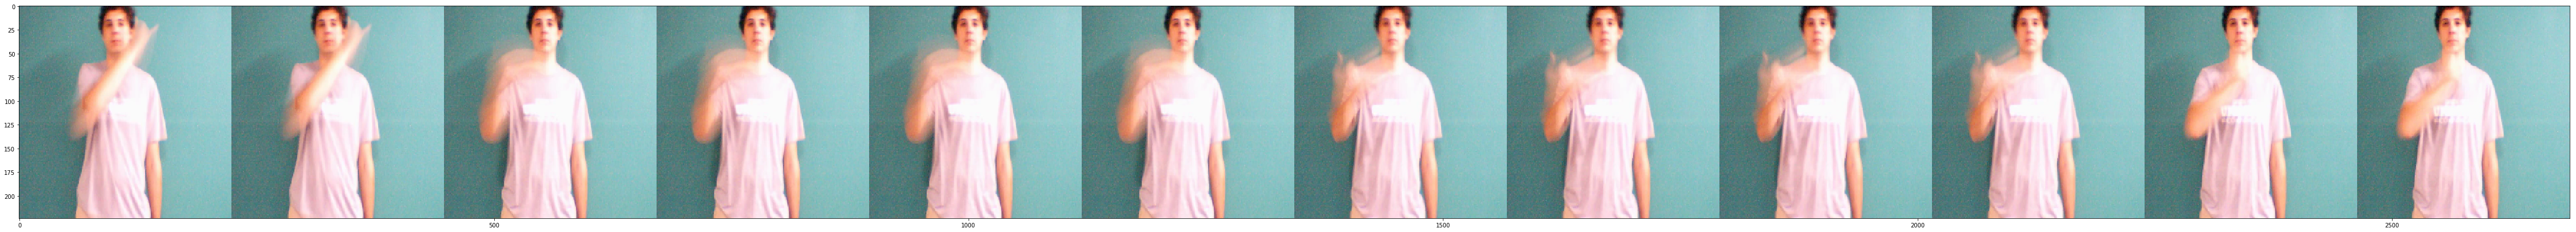

In [67]:
# visualiza um video
img = np.concatenate([interval_mapping(img, np.min(img), np.max(img), 0, 255).astype(np.uint8)
                for img in batch[0]], axis=1)

plt.figure(figsize=(80,40))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [68]:
%%time
def nb_positive_per_class(model, gen, _class):
    nb = {}
    
    for c in _class:
        nb[c] = 0
    
    for i in range(len(vfeatures)):
        batch, label = next(gen)
        predict = model.predict(batch)
        if _class[np.argmax(predict, axis=1)] == _class[np.argmax(label, axis=1)]:
            nb[_class[np.argmax(label, axis=1)][0]] += 1
    
    return nb


stats = nb_positive_per_class(model, vgen, _class)
stats

CPU times: user 4min 40s, sys: 12.9 s, total: 4min 53s
Wall time: 4min 11s


In [70]:
# total 90
stats

{'agosto': 44,
 'avisar': 37,
 'avisar-me': 40,
 'branco': 66,
 'educado': 36,
 'entender': 49,
 'entender-não': 71,
 'esquecer': 64,
 'pessoa': 71,
 'quente': 55,
 'rápido': 48,
 'sentimento': 27}

# Log

60/80%


### Base7

- MobileNet(Frozen, 12x192x192x3)
- Conv3D([32,2,2,2], [64,3,3,3], [128,6,3,3], [256,12,6,6])
- Dense(256, 256, 12)
- elu
- SGD(1e-04, 1e-05, 3e-06, 1e-07, 5e-08)
- Data augmentation
    - start_offset_rg=5, 
    - rtrg=12, 
    - wrg=0.08, 
    - hrg=0.05, 
    - shrg=20, 
    - zrg=0.12,
- Batch(1)
- 12 classes

```
Epoch 1/4
6451/6451 [==============================] - 1310s 203ms/step - loss: 1.7996 - acc: 0.3148 - val_loss: 1.4632 - val_acc: 0.4028
Epoch 2/4
6451/6451 [==============================] - 1321s 205ms/step - loss: 1.1782 - acc: 0.5174 - val_loss: 1.2809 - val_acc: 0.4722
Epoch 3/4
6451/6451 [==============================] - 1348s 209ms/step - loss: 0.9558 - acc: 0.6011 - val_loss: 1.2823 - val_acc: 0.4843
Epoch 4/4
6451/6451 [==============================] - 1303s 202ms/step - loss: 0.8130 - acc: 0.6650 - val_loss: 1.3417 - val_acc: 0.5259
Epoch 5/7
6451/6451 [==============================] - 1307s 203ms/step - loss: 0.6894 - acc: 0.7188 - val_loss: 1.2276 - val_acc: 0.5296
Epoch 6/7
6451/6451 [==============================] - 1315s 204ms/step - loss: 0.6559 - acc: 0.7318 - val_loss: 1.1954 - val_acc: 0.5528
Epoch 7/7
6451/6451 [==============================] - 1312s 203ms/step - loss: 0.6433 - acc: 0.7427 - val_loss: 1.3305 - val_acc: 0.5241
Epoch 8/8
6451/6451 [==============================] - 1300s 201ms/step - loss: 0.6124 - acc: 0.7613 - val_loss: 1.2426 - val_acc: 0.5565
Epoch 9/9
6451/6451 [==============================] - 1319s 205ms/step - loss: 0.5931 - acc: 0.7644 - val_loss: 1.1799 - val_acc: 0.5870
Epoch 10/10
6451/6451 [==============================] - 1379s 214ms/step - loss: 0.5947 - acc: 0.7627 - val_loss: 1.0650 - val_acc: 0.5991
```


### Base6

- MobileNet(Frozen, 12x160x160x3)
- Conv3D(42, 86, 132, 316)
- Dense(256, 256, 12)
- elu
- SGD(0.0005, 0.000025, 0.000001)
- Data augmentation
    - start_offset_rg=5, 
    - rtrg=12, 
    - wrg=0.08, 
    - hrg=0.05, 
    - shrg=20, 
    - zrg=0.12,
- Batch(1)
- 10 classes

```
Epoch 1/4
5371/5371 [==============================] - 1017s 189ms/step - loss: 1.4584 - acc: 0.4057 - val_loss: 1.1983 - val_acc: 0.5233
Epoch 2/4
5371/5371 [==============================] - 1004s 187ms/step - loss: 0.9272 - acc: 0.6006 - val_loss: 1.2665 - val_acc: 0.5456
Epoch 3/4
5371/5371 [==============================] - 1017s 189ms/step - loss: 0.7753 - acc: 0.6747 - val_loss: 1.3826 - val_acc: 0.5300
Epoch 4/4
5371/5371 [==============================] - 1006s 187ms/step - loss: 0.6079 - acc: 0.7336 - val_loss: 1.1440 - val_acc: 0.5733
Epoch 5/7
5371/5371 [==============================] - 969s 180ms/step - loss: 0.4738 - acc: 0.8004 - val_loss: 1.0135 - val_acc: 0.6367
Epoch 6/7
5371/5371 [==============================] - 967s 180ms/step - loss: 0.4094 - acc: 0.8326 - val_loss: 1.1812 - val_acc: 0.6111
Epoch 7/7
5371/5371 [==============================] - 967s 180ms/step - loss: 0.3862 - acc: 0.8429 - val_loss: 1.1450 - val_acc: 0.6456
Epoch 8/10
5371/5371 [==============================] - 968s 180ms/step - loss: 0.3771 - acc: 0.8479 - val_loss: 0.9466 - val_acc: 0.6778
Epoch 9/10
5371/5371 [==============================] - 966s 180ms/step - loss: 0.3718 - acc: 0.8542 - val_loss: 1.0065 - val_acc: 0.6633
Epoch 10/10
5371/5371 [==============================] - 965s 180ms/step - loss: 0.3844 - acc: 0.8434 - val_loss: 1.0358 - val_acc: 0.6456
```


- MobileNet(Frozen, 12x160x160x3)
- Conv3D(32, 64, 128, 256)
- Dense(256, 256, 12)
- elu
- SGD(0.0005, 0.000025, 0.000001)
- Data augmentation
    - start_offset_rg=5, 
    - rtrg=12, 
    - wrg=0.08, 
    - hrg=0.05, 
    - shrg=20, 
    - zrg=0.12,
- Batch(1)
- 10 classes

```
Epoch 1/4
5371/5371 [==============================] - 943s 175ms/step - loss: 1.5309 - acc: 0.3902 - val_loss: 1.5195 - val_acc: 0.4400
Epoch 2/4
5371/5371 [==============================] - 937s 174ms/step - loss: 0.9288 - acc: 0.5973 - val_loss: 1.3640 - val_acc: 0.4944
Epoch 3/4
5371/5371 [==============================] - 934s 174ms/step - loss: 0.7676 - acc: 0.6747 - val_loss: 1.2348 - val_acc: 0.5600
Epoch 4/4
5371/5371 [==============================] - 941s 175ms/step - loss: 0.6268 - acc: 0.7345 - val_loss: 1.3939 - val_acc: 0.5600
Epoch 5/7
5371/5371 [==============================] - 908s 169ms/step - loss: 0.4586 - acc: 0.8133 - val_loss: 1.1218 - val_acc: 0.5967
Epoch 6/7
5371/5371 [==============================] - 905s 169ms/step - loss: 0.4234 - acc: 0.8311 - val_loss: 1.1243 - val_acc: 0.6333
Epoch 7/7
5371/5371 [==============================] - 904s 168ms/step - loss: 0.3966 - acc: 0.8408 - val_loss: 1.0472 - val_acc: 0.6300
Epoch 8/10
5371/5371 [==============================] - 902s 168ms/step - loss: 0.3851 - acc: 0.8429 - val_loss: 1.1079 - val_acc: 0.6111
Epoch 9/10
5371/5371 [==============================] - 897s 167ms/step - loss: 0.3803 - acc: 0.8455 - val_loss: 1.1782 - val_acc: 0.5911
Epoch 10/10
5371/5371 [==============================] - 900s 168ms/step - loss: 0.3932 - acc: 0.8382 - val_loss: 1.1197 - val_acc: 0.6144
```

### Base5

- MobileNet(Frozen, 12x160x160x3)
- Conv3D(32, 64, 64, 128, 128, 256)
- Dense(256, 256, 12)
- elu
- SGD(0.0005, 0.000025, 0.000001)
- Data augmentation
    - start_offset_rg=5, 
    - rtrg=12, 
    - wrg=0.08, 
    - hrg=0.05, 
    - shrg=20, 
    - zrg=0.12,
- Batch(1)
- 8 classes

['sentimento', 'agosto', 'avisar', 'avisar-me', 'quente', 'rápido', 'pessoa', 'esquecer']
```
Epoch 1/4
4291/4291 [==============================] - 918s 214ms/step - loss: 1.3646 - acc: 0.4339 - val_loss: 1.6119 - val_acc: 0.4292
Epoch 2/4
4291/4291 [==============================] - 995s 232ms/step - loss: 0.9288 - acc: 0.6094 - val_loss: 1.1859 - val_acc: 0.5444
Epoch 3/4
4291/4291 [==============================] - 1001s 233ms/step - loss: 0.7483 - acc: 0.6942 - val_loss: 1.2139 - val_acc: 0.5764
Epoch 4/4
4290/4291 [============================>.] - ETA: 0s - loss: 0.6162 - acc: 0.7417
Epoch 5/7
4291/4291 [==============================] - 944s 220ms/step - loss: 0.4556 - acc: 0.8206 - val_loss: 0.9776 - val_acc: 0.6528
Epoch 6/7
4291/4291 [==============================] - 849s 198ms/step - loss: 0.4234 - acc: 0.8264 - val_loss: 1.0364 - val_acc: 0.6778
Epoch 7/7
4291/4291 [==============================] - 879s 205ms/step - loss: 0.4093 - acc: 0.8446 - val_loss: 1.1918 - val_acc: 0.6486
Epoch 8/10
4291/4291 [==============================] - 842s 196ms/step - loss: 0.3884 - acc: 0.8592 - val_loss: 1.0500 - val_acc: 0.6486
Epoch 9/10
4291/4291 [==============================] - 857s 200ms/step - loss: 0.3806 - acc: 0.8502 - val_loss: 1.0088 - val_acc: 0.6583
Epoch 10/10
4291/4291 [==============================] - 843s 197ms/step - loss: 0.3835 - acc: 0.8569 - val_loss: 0.9497 - val_acc: 0.6681
```


### Base4

- MobileNet(Frozen, 12x160x160x3)
- Conv3D(64, 128, 256)
- Dense(256, 256, 12)
- elu
- SGD(0.0005, 0.00005, 0.000005)
- Data augmentation
    - start_offset_rg=5, 
    - rtrg=10, 
    - wrg=0.075, 
    - hrg=0.05, 
    - shrg=15, 
    - zrg=0.10,
- Batch(1)
- 6 classes

val_acc=70%, acc=>90%

### Base3

- MobilideNet(Frozen, 12x160x160x3)
- Conv3D(64)
- Dense(256, 256, 12)
- elu
- SGD(0.0005)
- Data augmentation
    - start_offset_rg=5, 
    - rtrg=10, 
    - wrg=0.075, 
    - hrg=0.05, 
    - shrg=15, 
    - zrg=0.10,
- Batch(1)
- 6 classes 

['sentimento', 'agosto', 'avisar', 'avisar-me', 'quente', 'rápido']
```
:lr=0.0005
Epoch 1/6
3220/3220 [==============================] - 482s 150ms/step - loss: 1.8459 - acc: 0.1829 - val_loss: 1.8036 - val_acc: 0.1833
Epoch 2/6
3220/3220 [==============================] - 475s 147ms/step - loss: 1.5759 - acc: 0.3106 - val_loss: 1.5970 - val_acc: 0.3148
Epoch 3/6
3220/3220 [==============================] - 474s 147ms/step - loss: 1.3976 - acc: 0.3916 - val_loss: 1.6251 - val_acc: 0.3630
Epoch 4/6
3220/3220 [==============================] - 480s 149ms/step - loss: 1.1801 - acc: 0.4885 - val_loss: 1.8511 - val_acc: 0.3704
Epoch 5/6
3220/3220 [==============================] - 492s 153ms/step - loss: 1.0402 - acc: 0.5236 - val_loss: 1.4470 - val_acc: 0.3278
Epoch 6/6
3220/3220 [==============================] - 494s 153ms/step - loss: 0.9473 - acc: 0.5581 - val_loss: 1.6402 - val_acc: 0.3741
:lr=0.0001
Epoch 7/12
3220/3220 [==============================] - 468s 145ms/step - loss: 0.6532 - acc: 0.6708 - val_loss: 1.8062 - val_acc: 0.4315
Epoch 8/12
3220/3220 [==============================] - 467s 145ms/step - loss: 0.6098 - acc: 0.6984 - val_loss: 1.5671 - val_acc: 0.4796
Epoch 9/12
3220/3220 [==============================] - 455s 141ms/step - loss: 0.5730 - acc: 0.7224 - val_loss: 1.9466 - val_acc: 0.4685
Epoch 10/12
3220/3220 [==============================] - 459s 143ms/step - loss: 0.5342 - acc: 0.7453 - val_loss: 1.5947 - val_acc: 0.5019
Epoch 11/12
3220/3220 [==============================] - 463s 144ms/step - loss: 0.5128 - acc: 0.7416 - val_loss: 1.8927 - val_acc: 0.5000
Epoch 12/12
3220/3220 [==============================] - 480s 149ms/step - loss: 0.4804 - acc: 0.7677 - val_loss: 1.7507 - val_acc: 0.5148
:lr=0.00001
Epoch 13/18
3220/3220 [==============================] - 461s 143ms/step - loss: 0.4306 - acc: 0.8016 - val_loss: 1.6398 - val_acc: 0.5167
Epoch 14/18
3220/3220 [==============================] - 458s 142ms/step - loss: 0.4183 - acc: 0.8037 - val_loss: 1.8067 - val_acc: 0.5241
Epoch 15/18
3220/3220 [==============================] - 461s 143ms/step - loss: 0.4447 - acc: 0.7953 - val_loss: 1.7954 - val_acc: 0.4907
Epoch 16/18
3220/3220 [==============================] - 457s 142ms/step - loss: 0.4158 - acc: 0.8062 - val_loss: 1.7906 - val_acc: 0.5315
Epoch 17/18
3220/3220 [==============================] - 459s 143ms/step - loss: 0.4053 - acc: 0.8093 - val_loss: 1.7162 - val_acc: 0.5019
Epoch 18/18
3220/3220 [==============================] - 463s 144ms/step - loss: 0.4248 - acc: 0.8040 - val_loss: 1.7255 - val_acc: 0.4981
```
- 12x128x128x3
- SGD(0.0001)

```
Epoch 1/6
3220/3220 [==============================] - 369s 115ms/step - loss: 1.6311 - acc: 0.3230 - val_loss: 1.4906 - val_acc: 0.3667
Epoch 2/6
3220/3220 [==============================] - 364s 113ms/step - loss: 1.1128 - acc: 0.5292 - val_loss: 1.3460 - val_acc: 0.4463
Epoch 3/6
3220/3220 [==============================] - 366s 114ms/step - loss: 0.9534 - acc: 0.6003 - val_loss: 1.4451 - val_acc: 0.4944
Epoch 4/6
3220/3220 [==============================] - 366s 114ms/step - loss: 0.8389 - acc: 0.6463 - val_loss: 1.7043 - val_acc: 0.4556
Epoch 5/6
3220/3220 [==============================] - 368s 114ms/step - loss: 0.7526 - acc: 0.6857 - val_loss: 1.7641 - val_acc: 0.4722
Epoch 6/6
3220/3220 [==============================] - 370s 115ms/step - loss: 0.6643 - acc: 0.7233 - val_loss: 1.4899 - val_acc: 0.5500
Epoch 1/6
3220/3220 [==============================] - 365s 113ms/step - loss: 0.5071 - acc: 0.7966 - val_loss: 1.5901 - val_acc: 0.5167
Epoch 2/6
3220/3220 [==============================] - 364s 113ms/step - loss: 0.4368 - acc: 0.8326 - val_loss: 1.4532 - val_acc: 0.5093
Epoch 3/6
3220/3220 [==============================] - 359s 111ms/step - loss: 0.4334 - acc: 0.8267 - val_loss: 1.3962 - val_acc: 0.5667
Epoch 4/6
3220/3220 [==============================] - 371s 115ms/step - loss: 0.4098 - acc: 0.8407 - val_loss: 1.6664 - val_acc: 0.5000
Epoch 5/6
3220/3220 [==============================] - 380s 118ms/step - loss: 0.4056 - acc: 0.8376 - val_loss: 1.5598 - val_acc: 0.5370
```


- MobilideNet(Frozen, 12x160x160x3)
- Conv3D(64)
- Dense(256, 256, 12)
- elu
- SGD(0.0005)
- Data augmentation
    - start_offset_rg=5, 
    - rtrg=10, 
    - wrg=0.075, 
    - hrg=0.05, 
    - shrg=15, 
    - zrg=0.10,
- Batch(1)
- 3 classes 

['pessoa', 'educado', 'quente']
```
Epoch 1/6
1606/1606 [==============================] - 256s 159ms/step - loss: 0.5029 - acc: 0.7989 - val_loss: 0.4258 - val_acc: 0.9111
Epoch 2/6
1606/1606 [==============================] - 240s 150ms/step - loss: 0.1060 - acc: 0.9658 - val_loss: 0.4660 - val_acc: 0.8593
Epoch 3/6
1606/1606 [==============================] - 244s 152ms/step - loss: 0.1101 - acc: 0.9664 - val_loss: 0.2411 - val_acc: 0.9296
Epoch 4/6
1606/1606 [==============================] - 248s 154ms/step - loss: 0.0824 - acc: 0.9701 - val_loss: 0.4025 - val_acc: 0.8741
Epoch 5/6
1606/1606 [==============================] - 238s 148ms/step - loss: 0.0508 - acc: 0.9838 - val_loss: 0.1758 - val_acc: 0.9407
Epoch 6/6
1606/1606 [==============================] - 243s 151ms/step - loss: 0.0258 - acc: 0.9919 - val_loss: 0.1955 - val_acc: 0.9444
```

['agosto', 'avisar', 'avisar-me']
- SGD(0.0001)
```
Epoch 1/6
1610/1610 [==============================] - 250s 155ms/step - loss: 0.9061 - acc: 0.5689 - val_loss: 0.5783 - val_acc: 0.8037
Epoch 2/6
1610/1610 [==============================] - 255s 159ms/step - loss: 0.4902 - acc: 0.7950 - val_loss: 0.5432 - val_acc: 0.7519
Epoch 3/6
1610/1610 [==============================] - 249s 154ms/step - loss: 0.3216 - acc: 0.8770 - val_loss: 0.5034 - val_acc: 0.7963
Epoch 4/6
1610/1610 [==============================] - 249s 155ms/step - loss: 0.2532 - acc: 0.8944 - val_loss: 0.5498 - val_acc: 0.7630
Epoch 5/6
1610/1610 [==============================] - 249s 155ms/step - loss: 0.2056 - acc: 0.9224 - val_loss: 0.6670 - val_acc: 0.7704
Epoch 6/6
1610/1610 [==============================] - 250s 155ms/step - loss: 0.1654 - acc: 0.9348 - val_loss: 0.4727 - val_acc: 0.8000
```

### Base2 ['agosto', 'avisar', 'avisar-me']

- MobileNet(Frozen, 8x128x128)
- Conv3D(64)
- Dense(256, 12)
- relu
- SGD(0.001)
- No data augmentation
- Batch(1)
- 3 classes

```
Epoch 1/10
1610/1610 [==============================] - 134s 83ms/step - loss: 1.0978 - acc: 0.4186 - val_loss: 0.9970 - val_acc: 0.5815
Epoch 2/10
1610/1610 [==============================] - 130s 81ms/step - loss: 0.6693 - acc: 0.7112 - val_loss: 0.9825 - val_acc: 0.5778
Epoch 3/10
1610/1610 [==============================] - 129s 80ms/step - loss: 0.4198 - acc: 0.8503 - val_loss: 0.8425 - val_acc: 0.6185
Epoch 4/10
1610/1610 [==============================] - 124s 77ms/step - loss: 0.1833 - acc: 0.9317 - val_loss: 1.9822 - val_acc: 0.5037
Epoch 5/10
 698/1610 [============>.................] - ETA: 1:03 - loss: 0.0929 - acc: 0.9771
 ```
 
- MobileNet(Frozen, 8x128x128)
- Conv3D(64)
- Dense(256, 256, 12)
- SGD(0.001)
- No data augmentation
- Batch(1)
- 3 classes

```
Epoch 1/6
1610/1610 [==============================] - 139s 86ms/step - loss: 1.0070 - acc: 0.4733 - val_loss: 1.0304 - val_acc: 0.4556
Epoch 2/6
1610/1610 [==============================] - 129s 80ms/step - loss: 0.5549 - acc: 0.7683 - val_loss: 2.3620 - val_acc: 0.4222
Epoch 3/6
1610/1610 [==============================] - 129s 80ms/step - loss: 0.2888 - acc: 0.9006 - val_loss: 0.9042 - val_acc: 0.7000
Epoch 4/6
1610/1610 [==============================] - 130s 81ms/step - loss: 0.1133 - acc: 0.9665 - val_loss: 1.7556 - val_acc: 0.5926
Epoch 5/6
1610/1610 [==============================] - 128s 80ms/step - loss: 0.0835 - acc: 0.9752 - val_loss: 1.7697 - val_acc: 0.5704
Epoch 6/6
1610/1610 [==============================] - 137s 85ms/step - loss: 0.0398 - acc: 0.9894 - val_loss: 1.4568 - val_acc: 0.6815
```

- MobileNet(Frozen, 8x128x128)
- Conv3D(64)
- Dense(256, 256, 12)
- SGD(0.001)
- Data augmentation
    - start_offset_rg=5, 
    - rtrg=10, 
    - wrg=0.075, 
    - hrg=0.05, 
    - shrg=15, 
    - zrg=0.10,
    - toflip=False
- Batch(1)
- 3 classes

```
Epoch 1/6
1610/1610 [==============================] - 145s 90ms/step - loss: 10.7738 - acc: 0.3292 - val_loss: 11.0439 - val_acc: 0.3148
Epoch 2/6
1610/1610 [==============================] - 144s 90ms/step - loss: 10.7320 - acc: 0.3342 - val_loss: 11.0439 - val_acc: 0.3148
Epoch 3/6
1610/1610 [==============================] - 148s 92ms/step - loss: 10.5719 - acc: 0.3441 - val_loss: 10.1484 - val_acc: 0.3704
Epoch 4/6
1610/1610 [==============================] - 143s 89ms/step - loss: 10.7521 - acc: 0.3329 - val_loss: 11.2230 - val_acc: 0.3037
Epoch 5/6
1610/1610 [==============================] - 156s 97ms/step - loss: 10.5819 - acc: 0.3435 - val_loss: 10.6260 - val_acc: 0.3407
Epoch 6/6
  69/1610 [>.............................] - ETA: 2:38 - loss: 11.4462 - acc: 0.2899
 ```

- MobileNet(Frozen, 12x128x128)
- Conv3D(86)
- Dense(256, 256, 12)
- SGD(0.001)
- Data augmentation
    - start_offset_rg=5, 
    - rtrg=10, 
    - wrg=0.075, 
    - hrg=0.05, 
    - shrg=15, 
    - zrg=0.10,
    - toflip=False
- Batch(1)
- 3 classes

```
Epoch 1/6
1610/1610 [==============================] - 186s 116ms/step - loss: 1.0612 - acc: 0.4658 - val_loss: 0.9986 - val_acc: 0.4741
Epoch 2/6
1610/1610 [==============================] - 171s 106ms/step - loss: 0.7729 - acc: 0.6217 - val_loss: 0.9914 - val_acc: 0.4407
Epoch 3/6
1610/1610 [==============================] - 171s 106ms/step - loss: 0.5325 - acc: 0.7981 - val_loss: 0.8148 - val_acc: 0.6556
Epoch 4/6
1610/1610 [==============================] - 166s 103ms/step - loss: 0.3661 - acc: 0.8652 - val_loss: 1.3758 - val_acc: 0.5259
Epoch 5/6
1610/1610 [==============================] - 167s 103ms/step - loss: 0.2785 - acc: 0.8963 - val_loss: 0.8933 - val_acc: 0.6667
Epoch 6/6
1610/1610 [==============================] - 169s 105ms/step - loss: 0.2336 - acc: 0.9081 - val_loss: 2.7586 - val_acc: 0.4556
```

- MobileNet(::-6, 12x128x128)
- Conv3D(86)
- Dense(256, 256, 12)
- SGD(0.001)
- Data augmentation
    - start_offset_rg=5, 
    - rtrg=10, 
    - wrg=0.075, 
    - hrg=0.05, 
    - shrg=15, 
    - zrg=0.10,
    - toflip=False
- Batch(1)
- 3 classes

```
Epoch 1/6
1610/1610 [==============================] - 208s 129ms/step - loss: 10.6268 - acc: 0.3385 - val_loss: 11.1633 - val_acc: 0.3074
Epoch 2/6
1610/1610 [==============================] - 206s 128ms/step - loss: 10.8322 - acc: 0.3280 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 3/6
1610/1610 [==============================] - 199s 124ms/step - loss: 10.9923 - acc: 0.3180 - val_loss: 10.3872 - val_acc: 0.3556
Epoch 4/6
1610/1610 [==============================] - 201s 125ms/step - loss: 10.8522 - acc: 0.3267 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 5/6
1610/1610 [==============================] - 200s 124ms/step - loss: 11.0324 - acc: 0.3155 - val_loss: 10.9842 - val_acc: 0.3185
Epoch 6/6
1610/1610 [==============================] - 198s 123ms/step - loss: 10.6019 - acc: 0.3422 - val_loss: 10.5066 - val_acc: 0.3481
```

#### MobileNet -> LSTM/GRU(256) -> Dense(512) -> Dense(12) MAX_VAL_ACC 39% (Poderia melhor)
